# Token Benchmark Example Analysis
The following is an example of the analysis that can be done on individual responses that are saved when running `token_benchmark_ray.py` with the flag `--results-dir` which enables the saving of all responses.

In [7]:
import pandas as pd

In [14]:
# num_current_users = [1,4,8,16]
num_current_users = [16]

In [15]:
# path to the individual responses json file
df = pd.DataFrame()
for concurrent_user in num_current_users:
    df_user = pd.read_json(f'./../data/results/llmperf/sambanova-Llama-2-7b-chat_150_150_{concurrent_user}_individual_responses.json')
    # df_user = pd.read_json(f'sambanova-Llama-2-7b-chat_150_150_{concurrent_user}_individual_responses.json')
    df_user['concurrent_user'] = concurrent_user
    df = pd.concat([df,df_user])

In [16]:
def get_final_metrics_df(valid_df):
    final_df = pd.DataFrame()
    final_df["number_input_tokens"] = valid_df["number_input_tokens"]
    final_df["number_output_tokens"] = valid_df["number_output_tokens"]
    final_df["ttft_s"] = valid_df["ttft_s"]
    final_df["end_to_end_latency_s"] = valid_df["end_to_end_latency_s"]
    final_df["generation_throughput"] = valid_df["request_output_throughput_token_per_s"]
    final_df["concurrent_user"] = valid_df["concurrent_user"]
    return final_df

In [17]:
valid_df = df[(df["error_code"] != "")]
final_df = get_final_metrics_df(valid_df)

Text(0.5, 1.0, 'Number of output Tokens vs. Throughput')

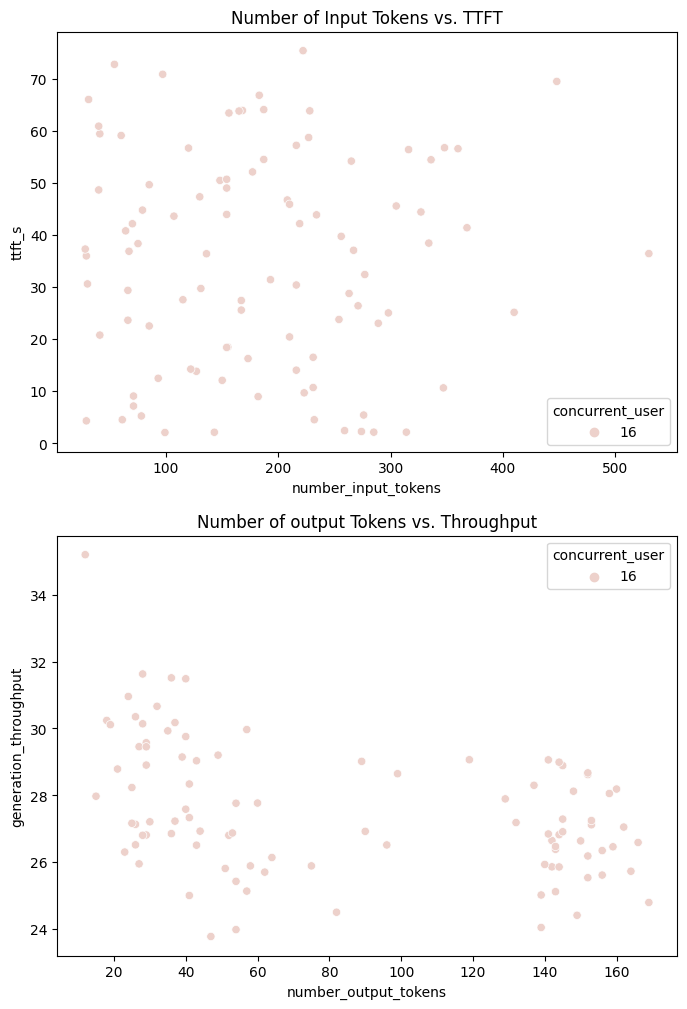

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(8,12))
sns.scatterplot(data=final_df, x="number_input_tokens", y="ttft_s", hue="concurrent_user", ax=ax[0]).set_title("Number of Input Tokens vs. TTFT")
sns.scatterplot(data=final_df, x="number_output_tokens", y="generation_throughput", hue="concurrent_user", ax=ax[1]).set_title("Number of output Tokens vs. Throughput")

<AxesSubplot: xlabel='generation_throughput'>

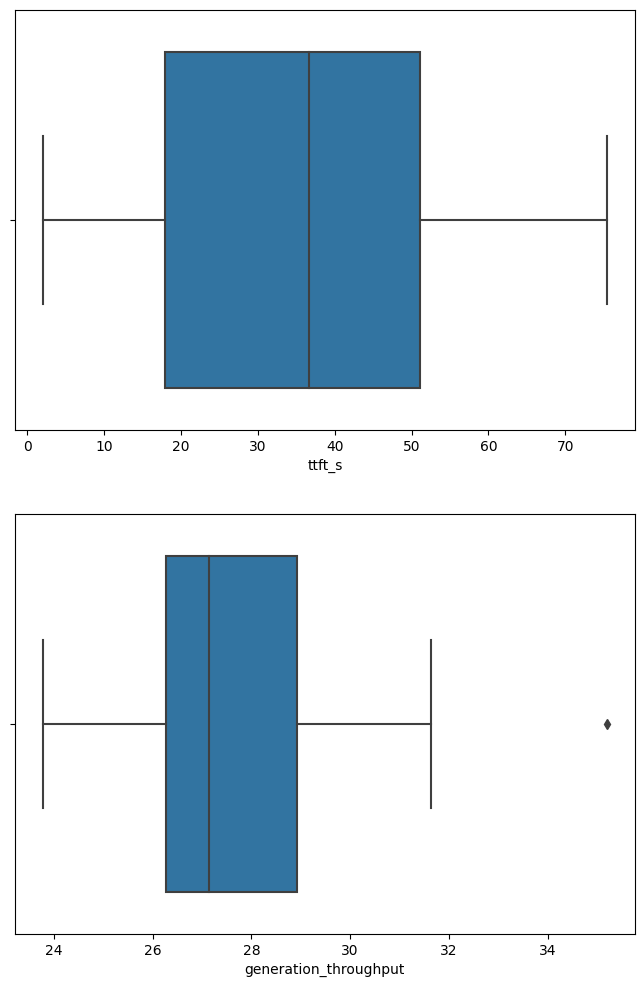

In [19]:
import seaborn as sns
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(8,12))
sns.boxplot(data=final_df, x="ttft_s", hue="concurrent_user", ax=ax[0])
sns.boxplot(data=final_df, x="generation_throughput", hue="concurrent_user", ax=ax[1])
